## Full Pipeline of Sequence Aggregation from Chan 4 Posts
Input - csv file with all relationships extracted <br />
Output - graph representation of trajectories

### Step 1: Listing Imports and Including the GloVE Vectors (300-dim from WIKI)

In [1]:
# BASIC IMPORTS OF ALL LIBRARIES
'''
Glove Imports are 300-dim from GENSIM
Pickle saves all the datasets
'''
from nltk import pos_tag
import csv
import re
import numpy as np
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from collections import defaultdict
import networkx as nx
from copy import deepcopy
import pickle
from entity_groups import *
from graphviz import Source
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist 
import gensim.downloader as api

wnl = WordNetLemmatizer()
word_vectors = api.load("glove-wiki-gigaword-300")

### Step 2: Defining filtering words that are illegal
#### Note: Entity mentions are ONLY valid if they exist in the entity mention list, all relationships are aggregated

In [6]:
# junk verbs that are generalizably illegal
junk_rel = ["be","have","do","let","","make","tell","say","describe","decide","want","name","know","think","try","become","oneday","put","come",'see', 'need', 'look', 'help', 'come', 'take', 'get', 'put', 'pick', 'turn', 'go', 'stand', 'give', 'notice', 'use',"get","start"]

# hypothetical words that are generally useless / qualifiers
# junk_words = ["would","could","should","maybe","perhaps","think","might","assume","claim"]
junk_words = ["this"]
# negative sentences
junk_words.extend(['n\'t',"not"])
print(junk_words)

# perspective actants that are pointless
# junk = ["you","i","we","the","it","he","she","steinbeck","people","author",
#         "book","me","steinback","him","her","their","this","","shelley","mary","harper","lee","tolkien"]
junk = []

['this', "n't", 'not']


### Step 3: EDIT these constraints to update pipeline spec

In [17]:
########################## EDIT DATE ##########################

DATE = "0412"

########################## CHOOSE ONE #########################

C = {}
#C = the_hobbit_C

C_use = {}
for key in C:
    for val in C[key]:
        C_use[val] = key

########################## CHOOSE ONE #########################
S = entities_5g_towers_begin_torched
print(S)
S_use = {}
for key in S:
    for val in S[key]:
        S_use[val] = key
print(S_use)
########################## CHOOSE ONE #########################
file_name = "5g-towers-being-torched/"
text = "5g_towers_being_torched"
#text = "the_hobbit"

{'us': ['us'], 'you': ['you'], 'me': ['me'], 'flu': ['flu', 'fever', 'virus'], 'we': ['we'], 'they': ['they'], 'them': ['them'], '5g': ['5g'], 'china': ['china', 'wuhan'], 'scam': ['scam'], 'dog': ['dogs', 'doggos', 'dog', 'doggo'], 'radiation': ['radiation'], 'waves': ['wave', 'waves'], 'fact': ['fact'], 'towers': ['towers', 'tower', 'radiotowers'], 'risk': ['risk'], 'cat': ['cat', 'cats'], 'bat': ['bat', 'bats']}
{'us': 'us', 'you': 'you', 'me': 'me', 'flu': 'flu', 'fever': 'flu', 'virus': 'flu', 'we': 'we', 'they': 'they', 'them': 'them', '5g': '5g', 'china': 'china', 'wuhan': 'china', 'scam': 'scam', 'dogs': 'dog', 'doggos': 'dog', 'dog': 'dog', 'doggo': 'dog', 'radiation': 'radiation', 'wave': 'waves', 'waves': 'waves', 'fact': 'fact', 'towers': 'towers', 'tower': 'towers', 'radiotowers': 'towers', 'risk': 'risk', 'cat': 'cat', 'cats': 'cat', 'bat': 'bat', 'bats': 'bat'}


### Step 4: Set the File Paths for the Pipeline

In [18]:
results_path = "Results" + DATE + "/" + text
adj_mat_path = "Precedence_Matrix/" + text
abs_adj_mat_path = "AbsPrecedence_Matrix/" + text
dic_path = "Dictionary/" + text + ".pickle"
ner_file = "../Covid_19_Data/Extracted_Data/chan4/" + file_name + "into_relex_relations_-1.csv"
fileName = ner_file

### Step 5: Extract Trajectories from Reviews

#### Step 5A: HELPER FUNCTIONS

In [4]:
# HELPER FUNCTION
def hypothetical_sentence(sent):
    '''
    Removes sentences that have the hypothetical list of words in them. 
    Does not offer information about sequencing.
    '''
    for word in sent.split():
        for ground_word in junk_words:
            if ground_word in word:
                return True
    return False

#### Step 5b: Aggregation of trajectories

In [8]:
trajectories = []
same_post = 0
traj = ["START"]

with open(fileName) as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')

    for row in readCSV:
        FLAG = 0

        sub_r = ""
        obj_r = ""
        sub_verb = ""

        if hypothetical_sentence(row[2]):
            continue

        try:
            sub = re.search(r"\{(\w+)\}", row[3]).group(1).lower()
            rel = wnl.lemmatize(re.search(r"\{(\w+)\}", row[4]).group(1).lower(), pos='v')
            obj = re.search(r"\{(\w+)\}", row[5]).group(1).lower()
        except:
            continue

        words = row[2].split()
        rel_words = []

        if rel == None or obj == None or sub == None:
            continue
        
        if same_post == row[0]:
            pass
        else:
            same_post = row[0]
            traj.append("TERMINATE")
            trajectories.append(traj)
            traj = ["START"]

        try:
            sub_r = S_use[sub]
        except:
            sub_r = sub
            FLAG += 1
        
        try:
            obj_r = S_use[obj]
        except:
            obj_r = obj
            FLAG += 1

        sub_verb = ""

        try:
            sub_verb = C_use[rel]
        except:
            sub_verb = rel

        if sub_r == obj_r or sub_r in junk or obj_r in junk or sub_verb in junk_rel or FLAG == 2:
            continue

        traj.append(sub_verb)
        traj.append(sub_r + "_" + obj_r)

# if we missed out on last post
if traj != "START":
    traj.append("TERMINATE")
    trajectories.append(traj)

print(trajectories)

[['START', 'TERMINATE'], ['START', 'lower', '5g_system', 'lower', '5g_system', 'TERMINATE'], ['START', 'TERMINATE'], ['START', 'TERMINATE'], ['START', 'kill', '5g_people', 'kill', '5g_people', 'instal', 'people_5g', 'laugh', 'people_5g', 'instal', 'people_china', 'instal', 'people_5g', 'TERMINATE'], ['START', 'damage', 'waves_material', 'realize', 'you_waves', 'damage', 'waves_material', 'TERMINATE'], ['START', 'TERMINATE'], ['START', 'TERMINATE'], ['START', 'burn', 'everybody_towers', 'TERMINATE'], ['START', 'kill', 'towers_chang', 'kill', 'towers_chang', 'TERMINATE'], ['START', 'TERMINATE'], ['START', 'create', 'radiation_defects', 'create', 'radiation_children', 'create', 'radiation_defects', 'TERMINATE'], ['START', 'TERMINATE'], ['START', 'connect', 'you_web', 'TERMINATE'], ['START', 'TERMINATE'], ['START', 'TERMINATE'], ['START', 'gtfo', 'operators_you', 'TERMINATE'], ['START', 'hit', 'china_hardest', 'TERMINATE'], ['START', 'TERMINATE'], ['START', 'TERMINATE'], ['START', 'kill', 

### Step 6: Aggregate trajectories to create precedence matrix

In [9]:
'''
VAR. DESCRIPTION:
(a) Precedence Matrix : [:,0],[0,:] correlate to the START node
                    [:,1],[1,:] correlate to the TERMINATE node
(b) trajectory : START , ... , ... , TERMINATE
(c) dictionary_of_labels : verbHeadword_subjectHeadword_objectHeadword -> index
'''
precedence_matrix = np.zeros((50000,50000))
dictionary_of_labels = {"START":0, "TERMINATE":1}
counter_of_labels = defaultdict(int)
max_rows = 1
max_cols = 1
counter = 2

for trajectory in trajectories:

    triplets = ["START"]
    index = 1

    while index < len(trajectory)-2:
        triplets.append(trajectory[index] + '_' + trajectory[index + 1])
        index += 2

    triplets.append("TERMINATE")

    for key,_ in enumerate(triplets[:-1]):
        if triplets[key] not in dictionary_of_labels:
            dictionary_of_labels[triplets[key]] = counter
            counter += 1
    
    triplet_temp = []

    for trip in triplets:
        if trip not in triplet_temp:
            triplet_temp.append(trip)

    triplets = triplet_temp

    for trip in triplets:
        counter_of_labels[trip] += 1

    alpha = 1.0

    for key in range(1,len(triplets)):
        key_hist = key-1

        while key_hist >= 0:
            max_cols = max(max_cols, dictionary_of_labels[triplets[key]])
            precedence_matrix[dictionary_of_labels[triplets[key_hist]]][dictionary_of_labels[triplets[key]]] += alpha
            alpha /= 1.0
            key_hist -= 1

precedence_matrix = precedence_matrix[:max_cols+1,:max_cols+1]

### Step 7: Inter-Actant Relationship Clustering

#### Step 7a: HELPER FUNCTIONS

In [10]:
# Relationship Clustering - Helper Function
mean_threshold = 3.0

def ordered_elbowkmeans_with_glove_and_labels(verbs, weights):
    output_temp = []
    vecs = []
    distortions = []
    degree = 1

    for i,verb in enumerate(verbs):
        for j in range(weights[i]):
            output_temp.append(verb)
            try:
                vecs.append(list(word_vectors[verb]))
            except:
                vecs.append([-1000]*300) # junk vector that won't affect the KMean

    vecs = np.array(vecs)

    for k in range(100): 
        try:
            kmeanModel = KMeans(n_clusters=(k+1)).fit(vecs) 
            if sum(np.min(cdist(vecs, kmeanModel.cluster_centers_, 
                        'euclidean'),axis=1)) / vecs.shape[0] < mean_threshold:
                        degree = k+1
                        break
        except:
            break

    kmeanModel.predict(vecs)
    labels = kmeanModel.labels_

    for label in list(set(labels)):

        positions = np.argwhere(labels == label)
        min_dist = 10000000
        index = -1
        dist = 0

        for k,position in enumerate(positions):
            sample = np.min(cdist(vecs[position[0]].reshape(1,-1), kmeanModel.cluster_centers_, 'euclidean'),axis=1)
            dist += sample
            if min_dist > sample:
                min_dist = sample
                index = k

        if dist / len(positions) > mean_threshold*2:
            continue

        if list(vecs[positions[0][0]]) == [-1000]*300: # resolved here
            continue

        for peroni in positions:
            output_temp[peroni[0]] = output_temp[positions[index][0]] # closest to the center

    output = []
    for val in output_temp:
        if val not in output:
            output.append(val)

    return output

#### Step 7b: RC Clustering from the Retrieved Precedence Matrix

In [11]:
new_mat = deepcopy(precedence_matrix)
new_dict = defaultdict(list)
rel_map = defaultdict(list)
other_dict = dictionary_of_labels
diction = {}

for key in other_dict:
    diction[other_dict[key]] = key

for key in diction:
    if diction[key] not in ["START","TERMINATE"]:
        splits = diction[key].partition("_")
        new_dict[splits[2]].append(splits[0])

for key in new_dict:
    verbs = new_dict[key]
    weights = []

    for verb in verbs:
        weights.append(counter_of_labels[verb + "_" + key])
    labels = ordered_elbowkmeans_with_glove_and_labels(verbs, weights)

    for num in range(len(labels)):
        rel_map[other_dict[labels[num] + "_" + key]].append(other_dict[verbs[num] + "_" + key])

#print([diction[i].partition("_")[0] for i in rel_map[other_dict["come_george_lennie"]]])

counter_of_labels_t = defaultdict(int)
for key in rel_map:

    for val in rel_map[key]:
        counter_of_labels_t[diction[key]] += counter_of_labels[diction[val]]
        if key != val:
            new_mat[key] = new_mat[key] + new_mat[val]
            new_mat[val] = 0

    new_mat_t = np.transpose(new_mat)

    for val in rel_map[key]:
        if key != val:
            new_mat_t[key] = new_mat_t[key] + new_mat_t[val]
            new_mat_t[val] = 0
            
    new_mat = np.transpose(new_mat_t)

#### TEST BENCH: Testing the Relative Frequency of Triplets

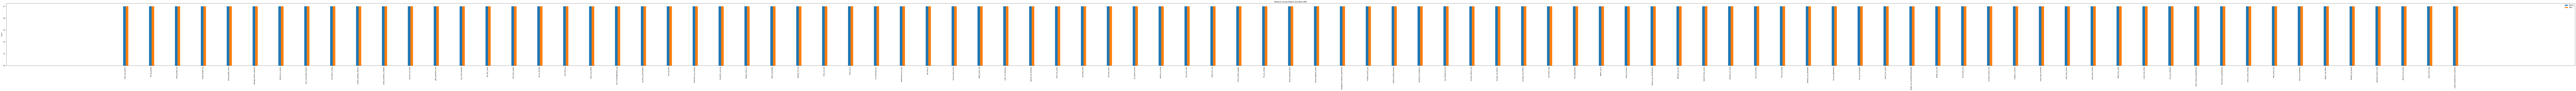

In [12]:
labels = list(counter_of_labels.keys())
labels.remove("START")
labels.remove("TERMINATE")
before_cluster = []
after_cluster = []

labels = labels
for label in labels:
    before_cluster.append(counter_of_labels[label])
    after_cluster.append(counter_of_labels_t[label])

x = np.arange(len(labels))
width = 0.10  # the width of the bars

fig, ax = plt.subplots(figsize=(320,8))
rects1 = ax.bar(x - width/2, before_cluster, width, label='Before')
rects2 = ax.bar(x + width/2, after_cluster, width, label='After')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Relative Counts before and after IARC')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
#ax.set_aspect(aspect=0.1)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right")

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', size = 2)

plt.show()


### Step 8: Remove Self Loops

In [13]:
for i in range(new_mat.shape[0]):
    new_mat[i][i] = 0.0

### Step 9: Normalize matrix and store count matrix

In [14]:
val_precedence_matrix = deepcopy(new_mat)

for row in new_mat:
    row[1] = 1.0/1000000.0

for i in range(len(new_mat[0])):
    if i >= 2:
        new_mat[0][i] = 1.0 / len(new_mat[0]-2)

for row in new_mat:
    sumt = sum(row)
    row /= sumt

#### TEST BENCH: (OPT) Potential For Saving Here!

In [20]:
np.save(adj_mat_path, new_mat)
np.save(abs_adj_mat_path, val_precedence_matrix)
with open(dic_path + "dict", 'wb') as handle:
    pickle.dump(dictionary_of_labels, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Step 10: Breadth First Search

#### Step 10a: Remove singles and pair-wise cycles in the adjacency matrix

In [21]:
mat = deepcopy(new_mat)
val_mat = deepcopy(val_precedence_matrix)

mat_s = deepcopy(mat)
mat_s[mat_s > 0.0] = 1
mat_st = np.transpose(mat_s)

singles = pair_wise_cycles = 0

# 1. remove pair-wise cycles
for i in range(0, mat.shape[0]):
    for j in range(0, mat.shape[1]):

        if mat[i][j] > mat[j][i]:
            if mat[j][i] != 0:
                pair_wise_cycles += 1.0
            mat[j][i] = 0

        elif mat[i][j] < mat[j][i]:
            if mat[i][j] != 0:
                pair_wise_cycles += 1.0
            mat[i][j] = 0

        elif mat[i][j] == mat[j][i] and i != j and mat[j][i] != 0:
            mat[j][i] = 0
            pair_wise_cycles += 1.0
            mat[i][j] = 0

#print("Number of Pair-Wise Cycles: ", pair_wise_cycles)
#print("Richness: ", np.sum(mat))

for i in range(0, mat.shape[1]):
    # no branches from triplet for TERMINATE AND START
    if np.sum(mat_st[i]) == 1 and np.sum(mat_s[i] == 1): 
        mat[i] = 0.0
        mat[0][i] = 0.0
        singles += 1.0

# We do not want to go from START -> TERMINATE directly.
mat[0][1] = 0.0
mat[1][1] = 0.0

#print("Number of Single Triplets: ", singles)

#### Step 10b: HELPER FUNCTIONS

In [22]:
def compute_metric(from_node, to_node, mat):
    '''
    Adjust the metric to keep in check the approach of the graph.
    '''
    trust = mat[from_node][to_node]
    mat_t = np.transpose(mat)
    in_degree = np.sum(mat_t[to_node] > 0)
    out_degree = np.sum(mat[to_node] > 0)
    #print(trust, out_degree + in_degree, val_mat[from_node][to_node])
    return trust + 0.001*(out_degree + in_degree) + 0.01*val_mat[from_node][to_node]
    #return trust*(out_degree + in_degree)


def not_cycle_from_to_node_to_from_node(from_node, to_node, mat_flow):
    '''
    Simple BFS: we do know that there are no cycles in here so
    no worries in computing a path from to to, to detemine cycle
    '''
    visited =[False]*mat_flow.shape[0] 
    #Create a queue for BFS 
    queue=[] 
    # Mark the source node as visited and enqueue it 
    queue.append(from_node) 
    visited[from_node] = True
    while queue: 
        #Dequeue a vertex from queue  
        n = queue.pop(0)      
        # If this adjacent node is the destination node, 
        # then return true 
        if n == to_node: 
            return False
        #  Else, continue to do BFS 
        to_nodes = np.argwhere(mat_flow[n] != 0)
        for i in to_nodes: 
            i = i[0]
            if visited[i] == False: 
                queue.append(i) 
                visited[i] = True
    # If BFS is complete without visited d 
    return True

#### STEP 10c: Breadth First Search

In [23]:
number_of_steps = 100
current_time = 0
stack_per_time = [0]
cycles = 0
cycles_prob = []
weight_of_discarded_edge = []

time_step = np.zeros_like(mat[0]) - 1.0
mat_flow = np.zeros_like(mat)

while current_time < number_of_steps:

    print(current_time)
    if stack_per_time == []:
        print("Max Time Limit: ", current_time)
        break
    
    new_stack = []
    for start_node in stack_per_time:
        metric = []
        to_nodes = np.argwhere(mat[start_node] != 0)

        for to_node in to_nodes:
            to_node = to_node[0]
            metric.append(compute_metric(start_node, to_node, mat))

        # what happens to those with no to-nodes like TERMINATE   
        try:
            n_metric = np.argsort(-1*np.array(metric))
            threshold = metric[n_metric[0]] * 0.05
        except:
            n_metrc = []
            threshold = 1000

        for i in range(len(n_metric)):
            if metric[n_metric[i]] > threshold:
                to_node_correct = to_nodes[n_metric[i]][0]

                if not_cycle_from_to_node_to_from_node(to_node_correct, start_node, mat_flow):
                    if to_node_correct not in new_stack:
                        new_stack.append(to_node_correct)
                    mat_flow[start_node][to_node_correct] = 1.0
                    time_step[to_node_correct] = current_time + 1.0
                    
                else:
                    if mat[start_node][to_node_correct] != 0:
                        cycles += 1
                        weight_of_discarded_edge.append(val_mat[start_node][to_node_correct])
                        # print(mat[start_node][to_node_correct], val_mat[start_node][to_node_correct], start_node, to_node_correct)

    stack_per_time = new_stack
    print(stack_per_time)
    current_time += 1

print("Total ignored cycles: ", cycles)
print("Weights of Removed Edges: ", weight_of_discarded_edge)

0
[78, 80, 77, 79, 69, 68, 49, 48, 47, 70, 4, 5, 6, 31, 66, 65, 73, 56, 55, 30, 72, 83, 18, 19, 22, 23, 37, 36, 84, 75, 51, 53, 43, 40, 25, 12, 8, 59, 88]
1
[79, 80, 1, 78, 70, 69, 49, 48, 5, 6, 66, 56, 31, 73, 84, 19, 23, 37]
2
[80, 1, 79, 70, 49, 6]
3
[1, 80]
4
[1]
5
[]
6
Max Time Limit:  6
Total ignored cycles:  0
Weights of Removed Edges:  []


### Step 11: Post-Processing

#### Step 11a: Removing Profuse Edges

In [24]:
for i in range(len(time_step)):
    for j in range(len(time_step)):
        if time_step[i] < time_step[j] and time_step[i] != -1 and time_step[j] != -1 and mat_flow[i][j] != 0:
            for k,source_node in enumerate(mat_flow[:][j]):
                if mat_flow[k][j] > 0 and k != i:
                    if not not_cycle_from_to_node_to_from_node(k,i, mat_flow):
                        mat_flow[k][j] = 0

#### Step 11b: Remove Singles that are meaningless

In [25]:
for i in range(0, mat_flow.shape[1]):
    # no branches from triplet for TERMINATE AND START
    if mat_flow[0][i] != 0 and mat_flow[i][1] != 0: 
        mat_flow[0][i] = 0.0
        mat_flow[i][1] = 0.0

## Final Step: Saving the graph to file

In [26]:
G = nx.from_numpy_matrix(mat_flow, create_using=nx.DiGraph)
DISP_THRESH = 2
bb = {}
for index, val in np.ndenumerate(val_mat):
    if val > 1:
        bb[index] = {"color":"red", "penwidth":2}
    else:
        bb[index] = {"color":"blue"}
nx.set_edge_attributes(G, bb)

bb1 = {}
for i in range(mat_flow.shape[0]):
    if np.sum(mat_flow[i]) + np.sum(np.transpose(mat_flow[i])) > DISP_THRESH:
        bb1[i] = {"color":"red", "penwidth":2}
    else:
        bb1[i] = {"color":"blue"}
nx.set_node_attributes(G, bb1)

In [27]:
H = nx.relabel_nodes(G, diction)
H.remove_nodes_from(list(nx.isolates(H)))
A = nx.nx_agraph.to_agraph(H)

for i in range(number_of_steps):
    same_priority = []
    for j in range(len(time_step)):
        if time_step[j] == i:
            same_priority.append(diction[j])
    one = A.add_subgraph(same_priority,rank='same')

A.layout('dot')
A.draw(results_path + '.png')